<a href="https://colab.research.google.com/github/santiagoprado12/Tesis/blob/main/Hallando_Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

In [85]:
df = pd.read_csv(r'Casos diarios.csv')

In [86]:
def derivSIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt



In [87]:
def modelSIR(V,R,N,beta,gamma):
    t = np.linspace(0,len(V)-1,len(V))
    y0 = N-V[0]-R[0],V[0],R[0]
    S,I,R = odeint(derivSIR, y0, t, args=(N, beta, gamma)).T
    dV = V
    dI = I
    return np.linalg.norm(dV-dI)

In [88]:
the_gamma = 1/21
def fitSIR(V,R,N):
    res = minimize(lambda x:modelSIR(V,R,N,x,the_gamma),
                            x0=0.5,method='powell')
    return res.x

In [89]:
def compute_paramsSIR(df,population, start_index, ndays):
  for i in range(start_index,len(df)-ndays):
      V = df['Infected'][i:i+ndays].to_numpy()
      R = df['Removed'][i:i+ndays].to_numpy()
      beta = fitSIR(V,R,population)
      df.loc[i,'Beta'] = beta
      df.loc[i,'Gamma'] = the_gamma

S=Poblacion total - Activos - recuperados - muertos

I=Activos

R=Recuperados + Muertos

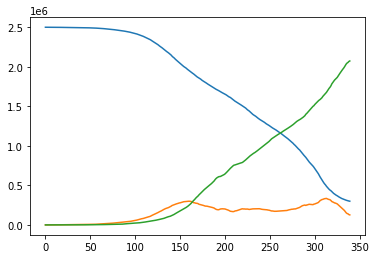

In [90]:
n=2500000
plt.plot(n-df['activos por dia']-df['acumulado recuperados']-df['acumulado muertes'])
plt.plot(df['activos por dia'])
plt.plot(df['acumulado recuperados']+df['acumulado muertes'])

In [91]:
df['Infected']=df['activos por dia']
df['Recovered']=df['acumulado recuperados']
df['Deaths']=df['acumulado muertes']
df['Removed'] = df['Recovered']+df['Deaths']

In [92]:
init_index=20
compute_paramsSIR(df,48200000, init_index, 3)
df['Rt'] = df['Beta'] / df['Gamma']

In [93]:
res=[]
N= 48200000
the_gamma = 1/21
I_a=df['Infected'][init_index]
res=[I_a]
R_a=df['Removed'][init_index]
S_a=N-I_a-R_a

for be in df['Beta'][init_index:]:
  t = np.linspace(0,1,2)
  y0 = S_a,I_a,R_a
  S,I,R = odeint(derivSIR, y0, t, args=(N, be, the_gamma)).T
  I_a=I[1]
  R_a=R[1]
  S_a=S[1]
  res.append(I[1])

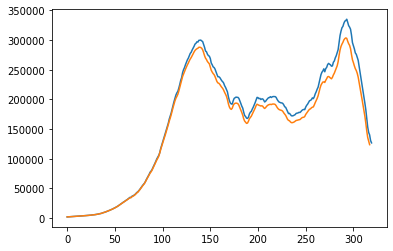

In [94]:
plt.plot(range(0,len(df['activos por dia'][init_index:])),df['activos por dia'][init_index:])
plt.plot(res)

In [95]:
df1 = pd.read_csv(r'Casos diarios.csv')

In [96]:
df1["Gamma"]=df["Gamma"]

In [97]:
df1["Beta"]=df["Beta"]

In [98]:
df1=df1[20:337]

In [99]:
df1

,fechas,casos por dia,fallecidos por dia,recuperados por dia,sintomaticos activos,acumulado muertes,acumulado recuperados,acumulado casos,acumulado sintomaticos,activos por dia,asintomaticos,Gamma,Beta
20,2020-03-26,154,2,16,132,8,43,2003,1930,1952,22,0.047619,0.111758
21,2020-03-27,149,3,18,124,10,59,2157,2062,2088,26,0.047619,0.105232
22,2020-03-28,163,5,33,113,13,77,2306,2186,2216,30,0.047619,0.094348
23,2020-03-29,113,1,29,82,18,110,2469,2299,2341,42,0.047619,0.085215
24,2020-03-30,143,5,35,100,19,139,2582,2381,2424,43,0.047619,0.084224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,2021-02-01,5413,271,16321,-9476,54941,1925350,2174215,169745,193924,24179,0.047619,-0.023994
333,2021-02-02,4594,265,19752,-16066,55212,1941671,2179628,160269,182745,22476,0.047619,-0.042456
334,2021-02-03,3731,266,17582,-11616,55477,1961423,2184222,144203,167322,23119,0.047619,-0.031196
335,2021-02-04,3588,264,12311,-6988,55743,1979005,2187953,132587,153205,20618,0.047619,-0.000387


In [100]:
df1.to_csv(r'Casos diarios y Beta.csv', index = False)